In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import random
import h5py
from keras.datasets import cifar10
from keras.models import *
from keras.layers import *
from keras.layers.core import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.regularizers import *
import theano.tensor as T
import theano
from theano.tensor.shared_randomstreams import RandomStreams
from sklearn import metrics
from skimage.measure import compare_ssim
from scipy.misc import toimage
from sklearn.preprocessing import *

import os
import random
import time
from skimage import io, exposure, feature, color, transform
import matplotlib
import matplotlib.pyplot as plt
import glob

import scipy.signal as sig
import operator
import math

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

Using Theano backend.
Using gpu device 1: GeForce GTX 690 (CNMeM is disabled, cuDNN 5105)


In [2]:
# parameters for sliding window, and window function (Hann)
STEP_SIZE = 480
OVERLAP_SIZE = 32
WINDOW_SIZE = STEP_SIZE + OVERLAP_SIZE
OVERLAP_FUNC = sig.hann(OVERLAP_SIZE * 2)

# directory that contains TIMIT files
TIMIT_DIR = "/home/sri/Desktop/timit"

# directory that contains .wav files to process
NUM_EPOCHS = 1
BATCH_SIZE = 64

# randomly shuffle data before partitioning into training/validation?
RANDOM_SHUFFLE = True

# sample rate of input file (used in MFCC calculation)
SAMPLE_RATE = 16000

In [3]:
from load_TIMIT import *
from windowingFunctions import *
from utility import *

In [4]:
# read in 100 WAVs from TIMIT training set
rawWaveforms = load_TIMIT_train(TIMIT_DIR, 1000)

Reading in .wav files...


In [5]:
# waveform preprocessing
def preprocessWaveform(waveform):   
    return waveform, ()
   
def unpreprocessWaveform(waveform, params):
    return waveform



# window preprocessing
def preprocessWindows(windows):
    # scale window between -1 and 1
    processed = np.copy(windows)
   
    mn = np.min(processed, axis = 1)
    mx = np.max(processed, axis = 1)

    maxabs = np.maximum(np.abs(mn), np.abs(mx))

    for i in xrange(0, processed.shape[0]):
        processed[i] /= maxabs[i]
    #processed *= 0.98
   
    #processed = (processed + 1.0) / 2.0
   
    return processed, (maxabs,)

def unpreprocessWindows(windows, params):
    # scale window from [-1, 1] to [-32768, 32768]
    scl = params[0]
   
    unprocessed = np.copy(windows)
    #unprocessed /= 0.98
   
    #nprocessed = (unprocessed * 2.0) - 1.0
   
    for i in xrange(0, unprocessed.shape[0]):
        unprocessed[i] *= scl[i]

    return unprocessed

In [6]:
# waveform preprocessing
processedWaveforms = np.copy(rawWaveforms)

# we maximize the volume of every waveform
for i in xrange(0, len(processedWaveforms)):
    processedWaveforms[i], _ = preprocessWaveform(processedWaveforms[i])

In [7]:
# extract windows
rawWindows = extractWindowsMultiple(processedWaveforms, STEP_SIZE, OVERLAP_SIZE,
                                    collapse = True)

# randomly shuffle data
if (RANDOM_SHUFFLE):
    rawWindows = np.random.permutation(rawWindows)

print "Raw windows shape: ", rawWindows.shape
print "Max: ", np.amax(rawWindows)
print "Min: ", np.amin(rawWindows)

Raw windows shape:  (101135, 512)
Max:  17885.0
Min:  -17139.0


In [8]:
# data augmentation goes here, at some point
augWindows = np.copy(rawWindows)

print "Aug windows shape: ", augWindows.shape

Aug windows shape:  (101135, 512)


In [9]:
processedWindows, pwParams = preprocessWindows(augWindows)

In [10]:
# reshape into vector form
processedWindows = np.reshape(processedWindows, (processedWindows.shape[0], WINDOW_SIZE, 1))

In [11]:
print processedWindows.shape

print np.mean(processedWindows, axis=None)
print np.std(processedWindows, axis=None)
print np.min(processedWindows, axis = None)
print np.max(processedWindows, axis = None)

(101135, 512, 1)
0.0179514
0.286117
-1.0
1.0


In [12]:
class PhaseShift1D(Layer):
    """ PhaseShift1D
    Takes vector of size: B x S x nF
    And returns vector: B x nS x F
    """
    def __init__(self, n, **kwargs):
        super(PhaseShift1D, self).__init__(**kwargs)
        self.n = n
    
    def build(self, input_shape):
        # no trainable parameters
        self.trainable_weights = []
    
    def call(self, x, mask=None):
        r = T.reshape(x, (x.shape[0], x.shape[1], x.shape[2] / self.n, self.n))
        r = T.transpose(r, (0, 1, 3, 2))
        r = T.reshape(r, (x.shape[0], x.shape[1] * self.n, x.shape[2] / self.n))
        return r

    def get_output_shape_for(self, input_shape):
        return (input_shape[0], input_shape[1] * self.n, input_shape[2] / self.n)
    
    def get_config(self):
        config = {'n' : self.n}
        base_config = super(PhaseShift1D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [13]:
b = np.array([[0.0, 1.1, 0.2, 1.6, -0.4], [0.1, 0.4, 0.9, 0.5, 0.1]])
print b

s = np.argsort(b, axis = -1)[:, -2:]
print s

col_idx = np.arange(b.shape[0])[:, None]

z = np.zeros_like(b)
z[col_idx, s] = 1
print z

o = np.multiply(z, b)
print o

s = np.argsort(b, axis = -1)[:, :-2]
col_idx = np.arange(b.shape[0])[:, None]
a = np.copy(b)
a[col_idx, s] = 0
print a


[[ 0.   1.1  0.2  1.6 -0.4]
 [ 0.1  0.4  0.9  0.5  0.1]]
[[1 3]
 [3 2]]
[[ 0.  1.  0.  1.  0.]
 [ 0.  0.  1.  1.  0.]]
[[ 0.   1.1  0.   1.6 -0. ]
 [ 0.   0.   0.9  0.5  0. ]]
[[ 0.   1.1  0.   1.6  0. ]
 [ 0.   0.   0.9  0.5  0. ]]


In [14]:
class SelectMax(T.Op):
    # properties attribute
    __props__ = ()
    
    def __init__(self, n):
        super(SelectMax, self).__init__()
        self.n = n
        
    def make_node(self, x):
        assert hasattr(self, '_props'), "Your version of theano is too old to support __props__."
        x = T.as_tensor_variable(x)
        return theano.Apply(self, [x], [x.type()])
    
    def perform(self, node, inputs, output_storage):
        x, = inputs
        z, = output_storage
        
        zero_idxs = np.argsort(np.abs(x), axis = -1)[:, :-self.n]
        col_idxs = np.arange(x.shape[0])[:, None]
        out = np.copy(x)
        x[col_idxs, zero_idxs] = 0
        z[0] = x
    
    def grad(self, input, output_gradients):
        x, = input
        g, = output_gradients
        
        zero_idxs = T.argsort(T.abs_(x), axis = -1)[:, :-self.n, None]
        
        idnt = T.eye(x.shape[-1])
        
        grad_mult = idnt[zero_idxs]
        grad_mult = T.sum(grad_mult, axis = -3)[:, 0, :]
        grad_mult = 1.0 - grad_mult
        
        out_grad = g * grad_mult
        
        return [out_grad]
        
    def infer_shape(self, node, i0_shapes):
        # output shape is same as input shape
        return i0_shapes

In [15]:
b = np.array([[0.0, 1.1, 0.2, 1.6, -0.4], [0.1, 0.4, 0.9, 0.5, 0.1]])
print b

kb = K.variable(b)
zero_idxs = T.argsort(kb, axis = -1)[:, :-2, None]
print zero_idxs.eval()

i = T.eye(kb.shape[-1])
print i.eval()

grad_mult = i[zero_idxs]
grad_mult = T.sum(grad_mult, axis = -3)[:, 0, :]
grad_mult = 1.0 - grad_mult
print grad_mult.eval()

print (kb * grad_mult).eval()

print "---------"

o = SelectMax(2)(b)
print o.eval()

[[ 0.   1.1  0.2  1.6 -0.4]
 [ 0.1  0.4  0.9  0.5  0.1]]
[[[4]
  [0]
  [2]]

 [[0]
  [4]
  [1]]]
[[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  1.]]
[[ 0.  1.  0.  1.  0.]
 [ 0.  0.  1.  1.  0.]]
[[ 0.          1.10000002  0.          1.60000002 -0.        ]
 [ 0.          0.          0.89999998  0.5         0.        ]]
---------
[[ 0.   1.1  0.   1.6  0. ]
 [ 0.   0.   0.9  0.5  0. ]]


In [17]:
from keras.activations import softmax, sigmoid

# lambda to compute MSE between 2 vectors
def mse_lambda(vects):
    x, y = vects
    return K.mean(K.square(x - y))

# freeze weights for stacked training
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

# we generate a new optimizer of the same kind for every model
# we train
def opti():
    return Adam()

input_dim = (WINDOW_SIZE, 1)
input_size = np.prod(input_dim)
bottleneck_size = 128


tau = K.variable(1.0, name = 'temperature')
anneal_rate = 0.02
min_temperature = 0.1






    
# uniform quantizer of code with NBINS bins
NBINS = 31
class CodeRound(T.Op):
    # properties attribute
    __props__ = ()
    
    def __init__(self):
        super(CodeRound, self).__init__()
        
    def make_node(self, x):
        assert hasattr(self, '_props'), "Your version of theano is too old to support __props__."
        x = T.as_tensor_variable(x)
        return theano.Apply(self, [x], [x.type()])
    
    def perform(self, node, inputs, output_storage):
        x, = inputs
        z, = output_storage
        
        s = (x + 1.0) / 2.0
        s = np.round(s * float(NBINS - 1)) / float(NBINS - 1)
        s = (s * 2.0) - 1.0
        
        z[0] = s
    
    def grad(self, input, output_gradients):
        # pass through gradients unchanged
        x, = input
        g, = output_gradients
        return [g]
        
    def infer_shape(self, node, i0_shapes):
        # output shape is same as input shape
        return i0_shapes


    
    
    



def activation():
    return LeakyReLU(0.3)#ThresholdedReLU()#Activation('tanh')
autoenc_init = 'he_uniform'

def encoder_residual_block(output_dim = 64, filt_size = 5, subsample = True, conv = True):
    def f(input):
        stride = 1
        #if (subsample):
        #    stride = 2
        
        conv1 = Convolution1D(output_dim, filt_size, border_mode = 'same',
                          init = autoenc_init, activation = 'linear',
                          subsample_length = stride, bias = True)(input)
        #act1 = LeakyReLU(0.3)(conv1)
        act1 = activation()(conv1)
        if (subsample):
            act1 = MaxPooling1D(2)(act1)
        
        conv2 = Convolution1D(output_dim, filt_size, border_mode = 'same',
                          init = autoenc_init, activation = 'linear',
                          bias = True)(act1)
        
        #'''
        residual = conv2
        if (conv):
            shortcut = Convolution1D(output_dim, 1, border_mode = 'same',
                                     init = autoenc_init, activation = 'linear',
                                     subsample_length = stride, bias = False)(input)
        else:
            shortcut = input
        
        if (subsample):
            shortcut = MaxPooling1D(2)(shortcut)
        
        m = merge([shortcut, residual], mode = 'sum')
        return m
        #return activation()(m)
        #'''
        #return LeakyReLU(0.3)(conv2)
    
    return f

def decoder_residual_block(output_dim = 64, filt_size = 5, upsample = True, conv = True):
    def f(input):
        conv1 = Convolution1D(output_dim, filt_size, border_mode = 'same',
                          init = autoenc_init, activation = 'linear',
                          bias = True)(input)
        act1 = activation()(conv1)
        if (upsample):
            act1 = UpSampling1D(2)(act1)
        
        conv2 = Convolution1D(output_dim, filt_size, border_mode = 'same',
                          init = autoenc_init, activation = 'linear',
                          bias = True)(act1)
        
        #'''
        residual = conv2
        if (conv):
            shortcut = Convolution1D(output_dim, 1, border_mode = 'same',
                                     init = autoenc_init, activation = 'linear',
                                     bias = False)(input)
        else:
            shortcut = input
        if (upsample):
            shortcut = UpSampling1D(2)(shortcut)
        
        m = merge([shortcut, residual], mode = 'sum')
        return m
        #return activation()(m)
        #'''
        #return LeakyReLU(0.3)(conv2)
    
    return f



# ---------------------------------------------------------------------------
# autoencoder: takes an audio window, compresses it, and tries to reconstruct it
# ---------------------------------------------------------------------------
def autoencoder_structure(dim):
    enc_input = Input(shape = dim)

    # (512x1) => (512x48)
    enc = encoder_residual_block(64, 5, False, True)(enc_input)
    
    # (512x48) => (256x48)
    enc = encoder_residual_block(64, 5, True, False)(enc)

    # (256x48) => (256x48)
    enc = encoder_residual_block(64, 5, False, False)(enc)
    
    # (256x48) => (256x48)
    enc = encoder_residual_block(64, 5, True, False)(enc)
    
    # (256x48) => (256x48)
    enc = encoder_residual_block(64, 5, False, False)(enc)
    
    # (128x48) => (128)
    enc = Convolution1D(1, 9, border_mode = 'same',
                              init = autoenc_init, activation = 'linear',
                              bias = False)(enc)
    #enc = UniformNoise(0.1)(enc)
    #enc = Lambda(piecewise_tanh)(enc)
    #enc = Lambda(lambda x : x + fixed_gaussian_noise[:x.shape[0]] * (1.0 - tau) * 4.0)(enc)
    enc = Activation('tanh')(enc)
    #enc = Lambda(piecewise_tanh)(enc)
    #enc = Activation('relu')(enc)
    #enc = Lambda(sampling)(enc)
    
    
    enc = Reshape((bottleneck_size,))(enc)
    
    #enc = Lambda(lambda x : SelectMax(32)(x))(enc)
    enc = Lambda(lambda x : CodeRound()(x))(enc)
    
    enc = Model(input = enc_input, output = enc)
    
    
    #dec_input = Input(shape = (bottleneck_size, num_cats))
    dec_input = Input(shape = (bottleneck_size,))
    dec = Reshape((128, 1,))(dec_input)
    
    # (256x1) => (256x48)
    dec = decoder_residual_block(64, 5, False, True)(dec)

    # (256x1) => (256x48)
    dec = decoder_residual_block(64, 5, True, False)(dec)
    
    # (256x48) => (256x48)
    dec = decoder_residual_block(64, 5, False, False)(dec)
    
    # (256x48) => (512x48)
    dec = decoder_residual_block(64, 5, True, False)(dec)
    
    # (512x48) => (512x48)
    dec = decoder_residual_block(64, 5, False, False)(dec)

    # (512x48) => (512x1)
    dec = Convolution1D(1, 9, border_mode = 'same',
                              init = autoenc_init, activation = 'tanh',
                              bias = False)(dec)
    
    dec = Model(input = dec_input, output = dec)
    
    return enc, dec

# ---------------------------------------------------------------------------
# discriminator: tries to differentiate between original and reconstructed samples
# ---------------------------------------------------------------------------
def discriminator_structure(dim):
    dsc = Sequential()
    
    dsc.add(GaussianNoise(0.05, input_shape = dim))
    
    dsc.add(Convolution1D(32, 5, border_mode='same', input_shape = dim,
                                    init = 'uniform',
                                    subsample_length = 2, activation = 'linear'))
    dsc.add(LeakyReLU(0.3))
    
    dsc.add(Convolution1D(32, 5, border_mode='same',
                                    init = 'uniform',
                                    activation = 'linear'))
    dsc.add(LeakyReLU(0.3))

    dsc.add(Convolution1D(32, 5, border_mode='same',
                                    init = 'uniform',
                                    subsample_length = 2, activation = 'linear'))
    dsc.add(LeakyReLU(0.3))
    
    dsc.add(Convolution1D(32, 5, border_mode='same',
                                    init = 'uniform',
                                    activation = 'linear'))
    dsc.add(LeakyReLU(0.3))
    
    dsc.add(Convolution1D(32, 5, border_mode='same',
                                    init = 'uniform',
                                    subsample_length = 2, activation = 'linear'))
    dsc.add(LeakyReLU(0.3))
    
    dsc.add(Flatten())
    
    dsc.add(Dense(48, activation = 'linear'))
    dsc.add(LeakyReLU(0.3))
    dsc.add(Dense(1, activation = 'sigmoid'))
    
    return dsc


# construct autoencoder to be used in adversarial training (AAC - Adversarial AutoenCoder)
# uhhhh... whoops i screwed up the acronym
aac_input = Input(shape = input_dim)
aac_enc, aac_dec = autoencoder_structure(input_dim)
aac_embedding = aac_enc(aac_input)
aac_reconstructed = aac_dec(aac_embedding)


aac_autoencoder = Model(input = [aac_input], output = [aac_reconstructed])
aac_autoencoder.compile(loss = 'mean_squared_error', optimizer = opti())



# construct discriminator: regular
regdsc_input_dim = (WINDOW_SIZE, 1)
regdsc_input = Input(shape = input_dim)
regdsc_struct = discriminator_structure(regdsc_input_dim)

regdsc_label = regdsc_struct(regdsc_input)
aac_reg_label = regdsc_struct(aac_reconstructed)
#aac_decode_label = regdsc_struct(aac_decode_recons)

def code_sparsity_constraint(placeholder, code):
    scaled = (code + 1.0) / 2.0
    return K.mean(scaled, axis = -1)



def code_binary_constraint(placeholder, code):
    scaled = (code + 1.0) / 2.0
    scaled = K.clip(scaled, 0.001, 0.999)
    
    entropy = -(scaled * K.log(scaled) + (1.0 - scaled) * K.log(1.0 - scaled))
    #entropy = K.clip(entropy, 0.03, 0.97)
    #scaled = (code + 1.0) / 2.0
    #entropy = K.minimum(K.abs(-1.0 - code), K.minimum(K.abs(code), K.abs(1.0 - code)))
    #entropy = K.clip(entropy, 0.01, 1.0)
    #entropy = K.sqrt(entropy)
    return K.mean(entropy, axis = -1)

def code_balance_constraint(placeholder, code):
    # code ranges from 0 to 1
    # we try to maximize the approx. variance of it
    var = K.var(code, axis = -1) + 0.001
    return (1.0 / var)
    #return K.abs(K.mean(code, axis = -1))

clip_point = 0.01
k = 0.5
def code_laplacian_constraint(placeholder, code):
    clipped = K.clip(K.abs(code), clip_point, 1.0)
    lk_norm = K.pow(clipped, k)
    return K.mean(lk_norm, axis = -1)


# compile model
loss_weights = [300.0, 5.0]
loss_functions = ['mean_squared_error', 'binary_crossentropy', code_laplacian_constraint]
n_discrim = 0
n_code = 1
lmult = len(loss_weights) - n_discrim - n_code


make_trainable(aac_autoencoder, False)

aac_discrim_reg = Model(input = [regdsc_input], output = [regdsc_label])
aac_discrim_reg.compile(loss = ['binary_crossentropy'], optimizer = opti())
aac_discrim_reg.summary()

aac_autoencoder.summary()

make_trainable(aac_discrim_reg, False)
make_trainable(aac_autoencoder, True)
model = Model(input = [aac_input], output = [aac_reconstructed] + \
                                            [aac_reg_label] * n_discrim + \
                                            [aac_embedding] * n_code)
model.compile(loss = loss_functions,
              loss_weights = loss_weights,
              optimizer = opti())
model.summary()



X_train = np.copy(processedWindows)
ntrain = X_train.shape[0]
discrim_epoch = False


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 512, 1)        0                                            
____________________________________________________________________________________________________
sequential_2 (Sequential)        (None, 1)             119201      input_8[0][0]                    
Total params: 119201
____________________________________________________________________________________________________
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 512, 1)        0                                            
______________________________________________________________________

In [18]:
def test_discriminator(discriminator, autoencoder, X, y, verbose = True):
    # verify discriminator was trained properly
    y_hat = discriminator.predict(X)
    y_hat[y_hat >= 0.5] = 1
    y_hat[y_hat < 0.5] = 0

    n_total = y.shape[0]
    n_correct = np.sum(np.ravel(y_hat) == y)

    acc = n_correct * 100.0 / n_total
    if (verbose):
        print "Discriminator accuracy: %0.02f pct (%d of %d) right"%(acc, n_correct, n_total)
    return acc

In [19]:
def autoencoderTest(waveFilename, prefix, autoencoder, verbose = True):
    [rate, data] = sciwav.read(waveFilename)
    processedWave, wparams = preprocessWaveform(data)
    windows = extractWindows(processedWave, STEP_SIZE, OVERLAP_SIZE)
    

    # first, write desired reconstruction
    transformed, tparams = preprocessWindows(windows)
    if (verbose):
        print transformed.shape
    
    desired = unpreprocessWindows(transformed, tparams)
    desired = reconstructFromWindows(desired, OVERLAP_SIZE, OVERLAP_FUNC)
    desired = unpreprocessWaveform(desired, wparams)
    #sciwav.write(prefix + "_res_desired.wav", rate, desired.astype(np.int16))
    
    # then, run NN on transformed windows
    transformed, tparams = preprocessWindows(windows)
    
    transformed = np.reshape(transformed, (transformed.shape[0], WINDOW_SIZE, 1))
    autoencOutput = autoencoder.predict(transformed, batch_size = BATCH_SIZE, verbose = (1 if verbose else 0))
    if (verbose):
        print autoencOutput.shape
    autoencOutput = np.reshape(autoencOutput, (autoencOutput.shape[0], WINDOW_SIZE))
    
    if (verbose):
        print autoencOutput.shape
    recons = unpreprocessWindows(autoencOutput, tparams)
    recons = reconstructFromWindows(recons, OVERLAP_SIZE, OVERLAP_FUNC)
    recons = unpreprocessWaveform(recons, wparams)
    
    sciwav.write(prefix + "_output.wav", rate, recons.astype(np.int16))
    
    metrics = [
        np.max(desired),
        np.min(desired),
        np.max(recons),
        np.min(recons),
        mse(recons, desired),
        avgErr(recons, desired)
    ]
    
    if (verbose):
        print "Max/min desired:", metrics[0], metrics[1]
        print "Max/min recons: ", metrics[2], metrics[3]
        print waveFilename, " mse: ", metrics[4]
        print waveFilename, " avg err: ", metrics[5]
        
    return metrics

In [20]:
# interleave numpy arrays of the same size along the first axis
def interleave(arr):    
    num = len(arr)
    
    r = np.empty(arr[0].shape)
    r = np.repeat(r, num, axis = 0)
    
    for i in xrange(0, num):
        r[i::num] = arr[i]

    return r

Epoch 1:
    1280: 0.597015619278  ['autoencoder not training'] 0.980000019073 
    Terminating epoch early (don't wanna overfit!)

    Total time for epoch: 12.9940311909s
    ----------------
    Evaluated the discriminator: 96.75% d_acc
    Total time for evaluation: 1.98523902893s
    ----------------
    Code histogram:
       Entropy: 3.52331000855
       Within 0 bin(s): 0.0
       Within 1 bin(s): 0.0
       Within 2 bin(s): 0.0


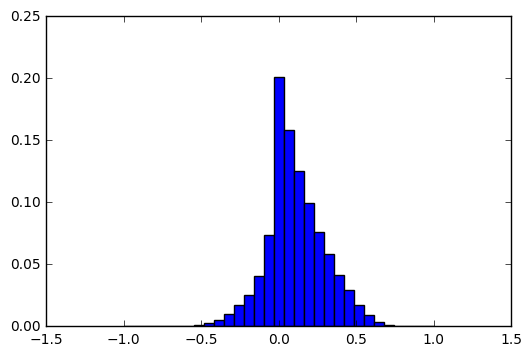

    ----------------
    Evaluating autoencoder...
    Max/min desired: 4899.0 -4013.0
    Max/min recons:  1181.64 -1146.96
    MSE:      119764.0
    Avg err:  182.955
    Total time for evaluation: 0.2185151577s

Epoch 2:
    1280: 0.55835545063  [7.786732 0.015350 0.996430 0.283584] [7.786732 5.372380 0.996430 1.417922] 0.132619559765 
    Total time for epoch: 602.006318092s
    ----------------
    Evaluated the discriminator: 73.75% d_acc
    Total time for evaluation: 0.42059803009s
    ----------------
    Code histogram:
       Entropy: 3.14761424813
       Within 0 bin(s): 0.0
       Within 1 bin(s): 0.0
       Within 2 bin(s): 0.0


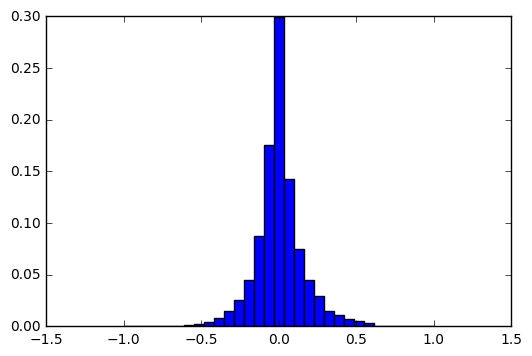

    ----------------
    Evaluating autoencoder...
    Max/min desired: 4899.0 -4013.0
    Max/min recons:  4321.05 -3215.34
    MSE:      10310.6
    Avg err:  53.3396
    Total time for evaluation: 0.213726997375s
    Updated binary constraint weight: 7.5

Epoch 3:
    1280: 0.714940428734  [8.522131 0.015588 1.064851 0.266873] [8.522131 5.455734 1.064851 2.001546] 0.10000000149 
    Total time for epoch: 604.756594896s
    ----------------
    Evaluated the discriminator: 50.0% d_acc
    Total time for evaluation: 0.420112848282s
    ----------------
    Code histogram:
       Entropy: 2.9740186226
       Within 0 bin(s): 0.0
       Within 1 bin(s): 0.0
       Within 2 bin(s): 0.0


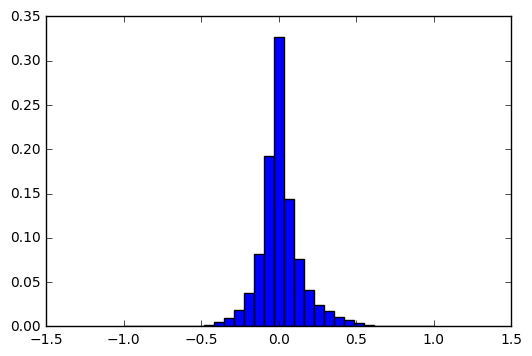

    ----------------
    Evaluating autoencoder...
    Max/min desired: 4899.0 -4013.0
    Max/min recons:  4249.78 -3360.48
    MSE:      9000.1
    Avg err:  50.7285
    Total time for evaluation: 0.2130651474s
    Updated binary constraint weight: 10.0

Epoch 4:
    1280: 0.735351383686  [13.416052 0.020654 3.861349 0.232586] [13.416052 7.228848 3.861349 2.325856] 0.10000000149

KeyboardInterrupt: 

In [21]:
np.set_printoptions(formatter={'float_kind':'{:4f}'.format})

BATCH_SIZE = 128
NUM_BATCHES = ntrain / BATCH_SIZE
NUM_EPOCHS = 50

lead = "    "
d_loss = 0.0
a_losses = []
d_acc = 0.0
discrim_train_y = np.concatenate((np.ones(ntrain), np.zeros(ntrain)))

for epoch in range(NUM_EPOCHS):
    print "Epoch " + str(epoch + 1) + ":"

    # present batches randomly each epoch
    lis = range(0, ntrain, BATCH_SIZE)
    random.shuffle(lis)
    
    # keep track of start time and current batch #
    i = 0
    startTime = time.time()
    for idx in lis:
        batch = X_train[idx:idx+BATCH_SIZE, :,  :]
        nbatch = batch.shape[0]
        
        a_losses = ["autoencoder not training"]
        d_loss = "discriminator not training"
        
        # train autoencoder, if discriminator accuracy is greater than 70%
        if (discrim_epoch or epoch > 0):
            make_trainable(aac_autoencoder, True)
            make_trainable(aac_discrim_reg, False)
            
            a_y = [batch] + \
                  [np.ones(nbatch)] * n_discrim + \
                  [np.zeros((nbatch, bottleneck_size))] * n_code
            a_losses = model.train_on_batch(batch, a_y)
        
        if (n_discrim > 0):
            #code = aac_enc.predict(batch)
            #code_binarized = np.sign(code)
            #c_losses = decoder_model.train_on_batch(code_binarized, [batch, np.ones(nbatch)])

            # train discriminator(s) on what the autoencoder now generates
            #generated = aac_dec.predict(code)
            #generated_binarized = aac_dec.predict(code_binarized)
            #discrim_batch_X = interleave([batch, generated, generated_binarized])
            #discrim_batch_y = interleave([np.ones(nbatch), np.zeros(nbatch), np.zeros(nbatch)])
            generated = aac_autoencoder.predict(batch)
            discrim_batch_X = interleave([batch, generated])
            discrim_batch_y = interleave([np.ones(nbatch), np.zeros(nbatch)])

            make_trainable(aac_autoencoder, False)
            make_trainable(aac_discrim_reg, True)
            d_loss = aac_discrim_reg.train_on_batch(discrim_batch_X, discrim_batch_y)
            
            if ((not discrim_epoch) and epoch == 0 and d_loss < 0.2):
                print ""
                print lead + "Terminating epoch early (don't wanna overfit!)"
                discrim_epoch = True
                break
        else:
            d_loss = -1
        
        # print statistics every 10 batches so we know stuff is still going down
        if (i % 10 == 0):
            printStr = "        \r" + lead + str(i * BATCH_SIZE) + ": " + str(d_loss) + " "
            print printStr,
            
            #'''
            loss_arr = np.asarray(a_losses)
            print loss_arr,
            
            if (len(loss_weights) > 1 and len(loss_arr) > 1):
                for i in xrange(0, len(loss_weights)):
                    loss_arr[i + 1] *= loss_weights[i]
                print loss_arr,
            
            #loss_arr = np.asarray(c_losses)
            #print loss_arr,
            #'''
            
            '''
            for l in [a_losses, c_losses]:
            #for l in [a_losses]:
                loss_arr = np.asarray(l)
                print loss_arr,

                if (len(loss_arr) > 1):
                    for i in xrange(0, len(loss_weights)):
                        loss_arr[i + 1] *= loss_weights[i]
                    print loss_arr,
            '''
            
            print K.get_value(tau),
            K.set_value(tau, np.max([K.get_value(tau) * (1 - anneal_rate), min_temperature]))
            
        i += 1
    print ""
    
    # print elapsed time for epoch
    elapsed = time.time() - startTime
    print lead + "Total time for epoch: " + str(elapsed) + "s"   
    
    # ---------------------------------------------------------
    # evaluate discriminator on random samples every epoch
    # ---------------------------------------------------------
    startTime = time.time()
    print lead + "----------------"
    if (n_discrim > 0):
        NUM = 200
        rows = np.random.randint(X_train.shape[0], size = NUM)
        generated = aac_autoencoder.predict(X_train[rows, :], verbose = 0)
        d_X = np.concatenate((X_train[rows, :], generated))
        d_y = np.concatenate((np.ones(NUM), np.zeros(NUM)))
        d_acc = test_discriminator(aac_discrim_reg, aac_autoencoder,
                                   d_X, d_y, verbose = False)

        print lead + "Evaluated the discriminator: " + str(d_acc) + "% d_acc"
        elapsed = time.time() - startTime
        print lead + "Total time for evaluation: " + str(elapsed) + "s"
    else:
        print lead + "No discriminator"
    
    
    # ---------------------------------------------------------
    # generate code histogram from said random samples
    # ---------------------------------------------------------
    NUM = 200
    rows = np.random.randint(X_train.shape[0], size = NUM)
    code = aac_enc.predict(X_train[rows, :], verbose = 0)
    
    print lead + "----------------"
    print lead + "Code histogram:"
    scalars = code.flatten()
    
    b = np.linspace(-1.0, 1.0, NBINS + 1)
    hist = np.histogram(scalars, bins = b)
    sample_hist_probs = hist[0].astype('float32')
    sample_hist_bins = hist[1].astype('float32')
    sample_hist_probs /= np.sum(sample_hist_probs)

    entropy = 0
    for i in sample_hist_probs:
        if (i < 1e-4): continue
        entropy += i * math.log(i, 2)
    entropy = -entropy
    print "       Entropy:", entropy
    
    for i in xrange(0, 3):
        print "       Within", i,  "bin(s):",
        tot = 0
        for j in xrange(0, i + 1):
            tot += sample_hist_probs[j]
            tot += sample_hist_probs[-(j+1)]
        print tot
        
    sample_hist_width = 1 * (sample_hist_bins[1] - sample_hist_bins[0])
    sample_hist_centers = (sample_hist_bins[:-1] + sample_hist_bins[1:]) / 2
    plt.figure()
    plt.bar(sample_hist_centers, sample_hist_probs, align='center', width=sample_hist_width)
    plt.show()
    
    # ---------------------------------------------------------
    # evaluate autoencoder on real data every epoch
    # ---------------------------------------------------------
    startTime = time.time()
    print lead + "----------------"
    
    print lead + "Evaluating autoencoder..."
    metrics = autoencoderTest("./SA1.WAV", "SA1_res_reg_train_epoch" + str(epoch+1), aac_autoencoder, verbose = False)
    
    print lead + "Max/min desired:", metrics[0], metrics[1]
    print lead + "Max/min recons: ", metrics[2], metrics[3]
    print lead + "MSE:     ", metrics[4]
    print lead + "Avg err: ", metrics[5]
    elapsed = time.time() - startTime
    print lead + "Total time for evaluation: " + str(elapsed) + "s"
    
    # ---------------------------------------------------------
    #'''
    # update loss weights every 2 epochs
    # ---------------------------------------------------------
    if (len(loss_weights) > 1 and n_code > 0 and epoch > 0):
        w_idx = 2
        if (n_discrim == 0): w_idx = 1

        if (loss_weights[w_idx] < 80.0):
            loss_weights[w_idx] += 2.5

            make_trainable(aac_discrim_reg, True)
            make_trainable(aac_autoencoder, True)
            model.compile(loss = loss_functions,
                          loss_weights = loss_weights,
                          optimizer = opti())
            print lead + "Updated binary constraint weight:", loss_weights[w_idx]
        else:
            print lead + "Didn't update binary constraint weight:", loss_weights[w_idx]
    #'''
    
    
    print ""

In [22]:
model.save('model_reg_adversary.h5')
aac_autoencoder.save('auto_reg_adversary.h5')

aac_discrim_reg.save('discrim_reg_adversary.h5')

import h5py

f = h5py.File('model_reg_adversary.h5', 'r+')
del f['optimizer_weights']
f.close()

In [23]:
'''from keras.models import load_model

objs = {'PhaseShift1D' : PhaseShift1D}

model = load_model('model_reg_adversary.h5', objs)
aac_autoencoder = load_model('auto_reg_adversary.h5', objs)
aac_discrim_reg = load_model('discrim_reg_adversary.h5', objs)
'''

"from keras.models import load_model\n\nobjs = {'PhaseShift1D' : PhaseShift1D}\n\nmodel = load_model('model_reg_adversary.h5', objs)\naac_autoencoder = load_model('auto_reg_adversary.h5', objs)\naac_discrim_reg = load_model('discrim_reg_adversary.h5', objs)\n"

In [24]:
enc = model.layers[1].layers
dec = model.layers[2].layers

In [25]:

'''
i = 0
print "-- Encoder --"
print ""
for e in enc:
    if type(e) is Convolution1D:
        i += 1
        print "Conv layer", i
        w = e.weights[0].eval()
        print "    Avg weight norm:", np.mean(np.abs(w))
        print "    Max weight norm:", np.max(np.abs(w))
        
        if (len(e.weights) == 1): continue
        b = e.weights[1].eval()
        print "    Avg bias norm:", np.mean(np.abs(b))
        print "    Max bias norm:", np.max(np.abs(b))
print ""

print "-- Decoder --"
print ""
for e in dec:
    if type(e) is Convolution1D:
        i += 1
        print "Conv layer", i
        w = e.weights[0].eval()
        print "    Avg weight norm:", np.mean(np.abs(w))
        print "    Max weight norm:", np.max(np.abs(w))
        
        if (len(e.weights) == 1): continue
        b = e.weights[1].eval()
        print "    Avg bias norm:", np.mean(np.abs(b))
        print "    Max bias norm:", np.max(np.abs(b))

#print [e.eval() for e in enc[-3].weights]
'''
0

0

In [26]:
NUM = 400
rows = np.random.randint(X_train.shape[0], size = NUM)
generated = aac_autoencoder.predict(X_train[rows, :], verbose = 0)
d_X = np.concatenate((X_train[rows, :], generated))
d_y = np.concatenate((np.ones(NUM), np.zeros(NUM)))
d_acc = test_discriminator(aac_discrim_reg, aac_autoencoder,
                           d_X, d_y, verbose = False)

print lead + "Evaluated the discriminator: " + str(d_acc) + "% d_acc"

    Evaluated the discriminator: 50.0% d_acc


In [27]:
autoencoderTest("./SA1.WAV", "SA1_aac_reg_", aac_autoencoder)
autoencoderTest("./SX383.WAV", "SX383_aac_reg_", aac_autoencoder)
autoencoderTest("./fiveYears.wav", "fy_aac_reg_", aac_autoencoder)

(112, 512)
112/112 [==============================] - 0s
(112, 512, 1)
(112, 512)
Max/min desired: 4899.0 -4013.0
Max/min recons:  4198.16 -3023.18
./SA1.WAV  mse:  10355.1
./SA1.WAV  avg err:  53.6532
(93, 512)
93/93 [==============================] - 0s
(93, 512, 1)
(93, 512)
Max/min desired: 2961.0 -3057.0
Max/min recons:  2777.26 -2661.44
./SX383.WAV  mse:  7808.12
./SX383.WAV  avg err:  42.8976
(181, 512)
181/181 [==============================] - 0s     
(181, 512, 1)
(181, 512)
Max/min desired: 24636.0 -20122.0
Max/min recons:  20829.3 -17064.4
./fiveYears.wav  mse:  1.58676e+06
./fiveYears.wav  avg err:  913.99


[24636.0, -20122.0, 20829.332, -17064.369, 1586764.4, 913.98987]

In [28]:
all_embed = aac_enc.predict(X_train[:10000], batch_size = BATCH_SIZE, verbose = 1)

10000/10000 [==============================] - 9s     


In [29]:
scalars = all_embed.flatten()
log_scalars = np.log((scalars + 1.0) / 2.0)

In [30]:
print np.mean(scalars)
print np.var(scalars)

0.0128236
0.0141005


0.0
0.0
0.0
0.0
0.0
9.3749999337e-06
7.96874996354e-05


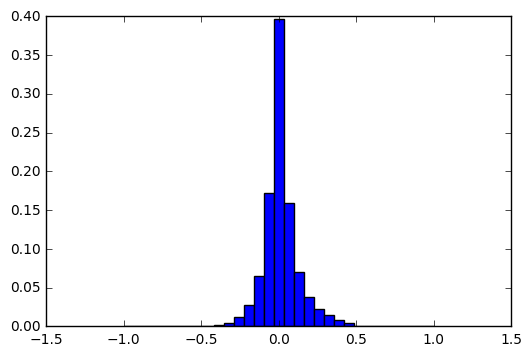

In [31]:
hist = np.histogram(scalars, bins = np.linspace(-1.0, 1.0, NBINS + 1))
sample_hist_probs = hist[0].astype('float32')
sample_hist_bins = hist[1].astype('float32')
sample_hist_probs /= np.sum(sample_hist_probs)

sample_hist_width = 1 * (sample_hist_bins[1] - sample_hist_bins[0])
sample_hist_centers = (sample_hist_bins[:-1] + sample_hist_bins[1:]) / 2
plt.bar(sample_hist_centers, sample_hist_probs, align='center', width=sample_hist_width)


for i in xrange(1, 8):
    p = 0
    for j in xrange(0, i):
        p += sample_hist_probs[j]
        p += sample_hist_probs[-j - 1]
    print p

plt.show()

In [32]:
[rate, data] = sciwav.read("./SA1.WAV")
processedWave, wparams = preprocessWaveform(data)
windows = extractWindows(processedWave, STEP_SIZE, OVERLAP_SIZE)

transformed, tparams = preprocessWindows(windows)

transformed = np.reshape(transformed, (transformed.shape[0], WINDOW_SIZE, 1))
embed = aac_enc.predict(transformed, batch_size = BATCH_SIZE, verbose = 1)

112/112 [==============================] - 0s


In [33]:
print embed[0]

r = np.copy(embed)
threshold = 0
#r[r < threshold] = -1.0
#r[r >= threshold] = 1.0
#r = np.round(r)
#r[(r < 0) & (r > -0.93)] = -0.936508
#r[(r > 0) & (r < 0.93)] = 0.936508
r = (r + 1.0) / 2.0
r = np.round(r * float(NBINS - 1))
qnt = r[0].astype('int')
r /= float(NBINS - 1)
r = (r * 2.0) - 1.0
#r = np.sign(r)

print r[0]
print qnt



autoencOutput = aac_dec.predict(r, batch_size = BATCH_SIZE, verbose = 1)
print autoencOutput.shape
autoencOutput = np.reshape(autoencOutput, (autoencOutput.shape[0], WINDOW_SIZE))

print autoencOutput.shape
recons = unpreprocessWindows(autoencOutput, tparams)

wav = reconstructFromWindows(recons, OVERLAP_SIZE, OVERLAP_FUNC)
wav = unpreprocessWaveform(wav, wparams)

sciwav.write("tst_output_reg.wav", rate, wav.astype(np.int16))

idx = 45

[0.133333 0.133333 0.000000 0.000000 0.066667 0.000000 0.400000 0.200000
 0.000000 0.066667 -0.066667 0.066667 0.133333 0.000000 0.133333 0.133333
 0.000000 -0.133333 0.000000 0.266667 0.000000 0.066667 0.200000 0.066667
 0.133333 -0.066667 0.133333 0.133333 0.066667 0.133333 0.000000 -0.066667
 0.133333 -0.066667 0.133333 0.000000 0.133333 0.133333 0.133333 0.066667
 -0.066667 0.066667 0.133333 0.066667 0.066667 0.200000 0.133333 0.066667
 -0.066667 0.066667 0.200000 0.066667 0.066667 0.133333 0.000000 0.000000
 0.000000 0.066667 0.133333 0.066667 0.133333 0.000000 0.000000 0.066667
 -0.133333 0.066667 0.133333 0.133333 0.066667 0.066667 0.066667 0.066667
 0.133333 0.133333 0.133333 0.000000 0.066667 0.066667 0.000000 0.066667
 0.000000 0.066667 0.066667 -0.200000 0.000000 0.000000 0.133333 0.000000
 0.000000 0.066667 0.000000 0.133333 0.066667 0.000000 0.000000 0.000000
 0.066667 0.066667 -0.066667 0.000000 0.066667 0.066667 0.066667 0.066667
 0.133333 0.066667 0.066667 0.066667 0.06

In [34]:
b = np.linspace(-1.0, 1.0, NBINS + 1)
print b

h = np.histogram(scalars, bins = b)
print h[0]
print h[0].sum()
print h[1]
h = h[0].astype('float32')
h = h / h.sum()
print h

entropy = 0
for i in h:
    if (i < 1e-4): continue
    entropy += i * math.log(i, 2)
entropy = -entropy
print entropy

entropy = 0
for idx in [0, 1, 2, -1, -2, -3]:
    i = h[idx]
    if (i < 1e-4): continue
    entropy += i * math.log(i, 2)
entropy = -entropy
print entropy

[-1.000000 -0.935484 -0.870968 -0.806452 -0.741935 -0.677419 -0.612903
 -0.548387 -0.483871 -0.419355 -0.354839 -0.290323 -0.225806 -0.161290
 -0.096774 -0.032258 0.032258 0.096774 0.161290 0.225806 0.290323 0.354839
 0.419355 0.483871 0.548387 0.612903 0.677419 0.741935 0.806452 0.870968
 0.935484 1.000000]
[     0      0      0      0      0      1     13    173    936   2719
   6299  14793  34625  83941 220861 508223 203720  89597  48800  28792
  18106  11291   5863   1159     77     11      0      0      0      0
      0]
1280000
[-1.000000 -0.935484 -0.870968 -0.806452 -0.741935 -0.677419 -0.612903
 -0.548387 -0.483871 -0.419355 -0.354839 -0.290323 -0.225806 -0.161290
 -0.096774 -0.032258 0.032258 0.096774 0.161290 0.225806 0.290323 0.354839
 0.419355 0.483871 0.548387 0.612903 0.677419 0.741935 0.806452 0.870968
 0.935484 1.000000]
[0.000000 0.000000 0.000000 0.000000 0.000000 0.000001 0.000010 0.000135
 0.000731 0.002124 0.004921 0.011557 0.027051 0.065579 0.172548 0.397049
 0.1